In [1]:
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=True

env: WANDB_SILENT=True


In [2]:
import os
# Make sure we're in the right directory
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [1]:
import sys
import h5py
import math
import json
import torch
import wandb
import hydra
import logging
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from typing import List, Dict, Sequence
from omegaconf import OmegaConf, DictConfig
from climart.data_transform.normalization import Normalizer
from climart.data_transform.transforms import AbstractTransform
from climart.data_loading.constants import LEVELS, LAYERS, GLOBALS, INPUT_TYPES
from climart.models.base_model import BaseModel
from climart.utils.wandb_api import get_wandb_ckpt_name

/space/hall5/sitestore/eccc/crd/ccrn/users/rau001/bin/envs/climart_gn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'climart'

In [4]:
plt.rcParams['figure.figsize'] = [20, 8]  # general matplotlib parameters
plt.rcParams['figure.dpi'] = 70 
os.environ['WANDB_SILENT']="true"
np.set_printoptions(suppress=True, threshold=sys.maxsize)

## *Please edit this part to point to the appropiate dir/filepaths where the input CanAM snapshots reside*

In [5]:
snapshot_dir = "/network/scratch/s/salva.ruhling-cachay/climart/raw_data/1979-2014/input_raw/2010-2014_205hours"
snapshot_dir = "/network/scratch/s/salva.ruhling-cachay/climart/raw_data/1979-2014/input_raw/1985-1989_205hours"
targets_pristine_dir = snapshot_dir.replace("input_raw", "output_pristine")
targets_clearsky_dir = snapshot_dir.replace("input_raw", "output_clear_sky")
snapshot_id = "0069519600"  # "0070395360"

snapshot_name = f'CanAM_snapshot_{snapshot_id}.nc'
snapshot_input_f = os.path.join(snapshot_dir, snapshot_name)
snapshot_target_pristine = os.path.join(targets_pristine_dir, snapshot_name)
snapshot_target_clearsky = os.path.join(targets_clearsky_dir, snapshot_name)

In [6]:
num_workers=2
device = "cuda" # or "cpu" or "cuda:0" or "cuda:1"

#### These are the Wandb IDs of the models we want to reload

In [7]:
pristine_sw_cnn_id = "ufhmccq6"  # only predicts SW pristine-sky radiation
pristine_sw_lw_mlp_id = "2r0l33yc"  # predicts SW and LW pristine-sky radiation
clearsky_sw_lw_mlp_id = "2z4kwhz4"  # predicts SW and LW clear-sky radiation

IDs = [pristine_sw_cnn_id, pristine_sw_lw_mlp_id, clearsky_sw_lw_mlp_id]
RUN_ALL = False

## Code to reload a model (its trained weights) from Wandb cloud

In [63]:
def reload_model(run_id: str, entity='ecc-mila7', project='ClimART', epoch=None):
    run_path = f"{entity}/{project}/{run_id}"
    best_model_path = get_wandb_ckpt_name(run_path, epoch=epoch)
    wandb.restore(best_model_path, run_path=run_path, replace=True, root=os.getcwd())  # download from the cloud
    
    config = wandb.restore("hydra_config.yaml", run_path=run_path, replace=True, root=os.getcwd())
    config = OmegaConf.load(config)
    assert config.logger.wandb.id == run_id, f"{config.logger.wandb.id} != {run_id}"
    # print_config(config, fields='all')
    seed_everything(config.seed, workers=True)
    model_state = torch.load(best_model_path)
    normalizer: Normalizer = hydra.utils.instantiate(config.normalizer, datamodule_config=config.datamodule, _recursive_=False)

    try:
        model: BaseModel = hydra.utils.instantiate(
            config.model, _recursive_=False,
            datamodule_config=config.datamodule,
            output_normalizer=normalizer.output_normalizer
        )
        model.load_state_dict(model_state['state_dict'])
    except Exception as e:
        logging.warning(" Current climart code state does not work for this model, trying older version.")
        config.model._target_ = config.model._target_.replace('climart.', 'climart_old_april1.')
        model: BaseModel = hydra.utils.instantiate(
            config.model, _recursive_=False,
            datamodule_config=config.datamodule,
            output_normalizer=normalizer.output_normalizer
        )
        model.load_state_dict(model_state['state_dict'])

    return model, config

## Now we also need code to pre-process the raw NetCDF4 snapshots to the data format the ML model expects...

In [10]:
add_coords=True
CACHE = {}

#### First some auxilary/not so important methods

In [11]:
INPUT_VARS_AEROSOLS = [
    'rhc',  # Relative humidity
    'aerin',  # Relative humidity
    'sw_ext_sa',  # Cloud water content horizontal variability parameter
    'sw_ssa_sa',  # solar flux up
    'sw_g_sa',  # heating rate (long-wave?)
    'lw_abs_sa'  # heating rate (short-wave?)
]
INPUT_VARS_CLOUDS = [
    'ccld',  # Cloud amount profile
    'anu',  # Cloud water content horizontal variability parameter
    'eta',  # Fraction black carbon in liquid cloud droplets
    'vtaurow',  # Vertically integrated optical thickness at 550 nm for stratospheric aerosols
    'troprow',  # Layer index of the tropopause
    'cldtrol',  # Total vertically projected cloud fraction
    'ncldy',  # Number of cloudy subcolumns in CanAM grid
    'rel_sub',  # Liquid cloud effective radius for subcolumns in CanAM grid
    'rei_sub',  # Ice cloud effective radius for subcolumns in CanAM grid
    'clw_sub',  # Liquid cloud water path for subcolumns in CanAM grid
    'cic_sub'
]
N_LAYERS = 49
N_LEVELS= N_LAYERS + 1

In [12]:
def pressure_from_level_array(levels_array):
    PRESSURE_IDX = 2
    return levels_array[..., PRESSURE_IDX]

def layer_thickness_from_layer_array(layers_array):
    THICKNESS_IDX = 12
    return layers_array[..., THICKNESS_IDX]

In [13]:
def compute_absolute_level_height(dz_layer_heights: xr.DataArray) -> xr.DataArray:
    """ Call with dz_layer_heights=YourDataset['dz'] """
    # layers=slice(None, None, -1) or levels=slice(None, None, -1) will simply reverse the data along that dim
    # Since levels=0 corresponds to TOA, this is needed, so that cumsum correctly accumulates from surface -> TOA
    surface_to_toa = dz_layer_heights.pad(layers=(0, 1), constant_values=0).sel(layers=slice(None, None, -1))
    # surface_to_toa[column = i] = [0, d_height_layer1, ..., d_height_lastLayer]
    level_abs_heights = surface_to_toa.cumsum(dim='layers').rename({'layers': 'levels'})
    toa_to_surface = level_abs_heights.sel(levels=slice(None, None, -1))  # reverse back to the existing format
    return toa_to_surface


def compute_temperature_diff(level_temps: xr.DataArray) -> xr.DataArray:
    """
    Usage:
        Call with level_temps=YourDataset['tfrow'], assuming that 'tfrow' is the temperature var. at the levels
    Returns:
        A xr.DataArray with same dimensions as level_temps, except for `levels` being replaced by `layer`.
        In the layer dimension, it will hold that:
            layer_i_tempDiff = level_i+1_temp - level_i_temp
        Note: This means that the temperature at *spatially higher* layers is subtracted from its adjacent lower layer.
            E.g., the layer next to the surface will get surface - level_one_above_surface
    """
    layer_temp_diffs = level_temps.diff(dim='levels', n=1).rename({'levels': 'layers'})
    return layer_temp_diffs

In [14]:
def reorder_input_variables(variable_names_list: List[str]):
    """ Reorders the list order, such that similar/equivalent variables come subsequently to each other"""
    tmp_list = variable_names_list.copy()
    ordered_vars = []
    # GLOBALS, Layers, levels
    ordered_vars += ['cszrow', 'shj', 'shtj']
    ordered_vars += ['gtrow', 'tlayer', 'tfrow']
    if 'layer_pressure' in variable_names_list:
        ordered_vars += ['pressg', 'layer_pressure', 'level_pressure']
    ordered_vars += ['oztop', 'ozphs']
    ordered_vars += ['qc']
    ordered_vars += ['dz']

    end_vars = []
    if 'x_cord' in variable_names_list:
        end_vars += ['x_cord', 'y_cord', 'z_cord']

    in_clouds = [v for v in INPUT_VARS_CLOUDS if v in tmp_list]
    in_aerosol = [v for v in INPUT_VARS_AEROSOLS if v in tmp_list]

    for var in ordered_vars + end_vars + in_clouds + in_aerosol:
        tmp_list.remove(var)

    ordered_vars += tmp_list
    ordered_vars += end_vars

    ordered_vars += in_aerosol
    ordered_vars += in_clouds
    return ordered_vars

#### And now first a method to open the NetCDF4 data as an xarray & add some extra variables to it  (while dropping irrelevant ones, e.g. those for cloudy sky)

In [15]:
def get_xarray_input_dataset(input_filename: str,
                       add_pressure: bool = True, add_temp_diff: bool = True, add_layer_thickness: bool = True,
                       add_absolute_level_height: bool = True, add_coords: bool = True, use_cache_for_coords: bool = True
                            ) -> xr.Dataset:
    remove_vars_in = ['iseed',
        'anu', 'eta', 'vtaurow', 'troprow',
        'ncldy', 'ccld', 'cldtrol',
        'clw_sub', 'cic_sub', 'rel_sub', 'rei_sub'
    ]
    input_dset = xr.open_dataset(input_filename, drop_variables=remove_vars_in, chunks={"longitude": 10, "latitude": 10})
    CACHE['latitude'] = list(input_dset.get_index('latitude'))
    CACHE['longitude'] = list(input_dset.get_index('longitude'))

    if add_coords:
        # Convert lat/lon to points on a unit sphere: https://datascience.stackexchange.com/a/13575
        if use_cache_for_coords and 'x_cord' in CACHE.keys():
            input_dset['x_cord'] = CACHE['x_cord']
            input_dset['y_cord'] = CACHE['y_cord']
            input_dset['z_cord'] = CACHE['z_cord']
        else:
            lat = list(input_dset.get_index('latitude'))
            lon = list(input_dset.get_index('longitude'))
            x_cord, y_cord, z_cord = [], [], []

            for i in lat:
                for j in lon:
                    x = math.cos(i) * math.cos(j)
                    y = math.cos(i) * math.sin(j)
                    z = math.sin(i)
                    x_cord.append(x)
                    y_cord.append(y)
                    z_cord.append(z)
            x_cord, y_cord, z_cord = np.array(x_cord), np.array(y_cord), np.array(z_cord)
            x_cord = x_cord.reshape((len(lat), len(lon)))
            y_cord = y_cord.reshape((len(lat), len(lon)))
            z_cord = z_cord.reshape((len(lat), len(lon)))

            dim_and_coords = dict(dims=('latitude', 'longitude'), coords={"latitude": lat, 'longitude': lon})
            input_dset['x_cord'] = xr.DataArray(data=x_cord, **dim_and_coords)
            input_dset['y_cord'] = xr.DataArray(data=y_cord, **dim_and_coords)
            input_dset['z_cord'] = xr.DataArray(data=z_cord, **dim_and_coords)
            if use_cache_for_coords:
                CACHE['x_cord'] = input_dset['x_cord']
                CACHE['y_cord'] = input_dset['y_cord']
                CACHE['z_cord'] = input_dset['z_cord']

    # Flatten spatial dimensions:
    input_dset = input_dset.stack(columns=['latitude', 'longitude'])

    if add_pressure:
        # pressure is of shape #levels x (lat x lon), shtj too, and pressg of shape (lat x lon)
        input_dset['layer_pressure'] = input_dset['shj'] * input_dset['pressg']
        input_dset['level_pressure'] = input_dset['shtj'] * input_dset['pressg']
    if add_layer_thickness:
        input_dset['layer_thickness'] = input_dset['dshj'] * input_dset['pressg']
    if add_temp_diff:
        input_dset['temp_diff'] = compute_temperature_diff(input_dset['tfrow'])
    if add_absolute_level_height:
        input_dset['height'] = compute_absolute_level_height(input_dset['dz'])

    return input_dset

#### And a method to map that xarray to the expected input, a str-> numpy array dictionary

In [16]:
def xarray_to_ml_model_raw_input(dataset: xr.Dataset) -> Dict[str, np.ndarray]:
    var_names = list(dataset.keys())
    dataset = dataset.transpose('columns', ...)  # bring spatial dim to the front
    dataset_size = dataset.sizes['columns']
    data_temp = {GLOBALS: None, LEVELS: None, LAYERS: None}
    # Order equivalent vars to same channel for different components:
    ordered_var_names = reorder_input_variables(var_names)
    for var_name in ordered_var_names:
        var_data = dataset[var_name].values
        if len(np.unique(var_data)) <= 1:
            print(f'{var_name} only has one value: {np.unique(var_data)[0]}!')
            if np.unique(var_data)[0] == 0:
                print("Dropping", var_name)
                continue

        # GLOBALS
        dim_names = dataset[var_name].dims
        if len(var_data.shape) <= 1 or ('layers' not in dim_names and 'levels' not in dim_names):
            var_type = GLOBALS
            var_data = var_data.reshape(dataset_size, -1)  # num_features = var_data.shape[1]
        # LEVEL VAR
        elif 'levels' in dim_names:
            var_type = LEVELS
            var_data = var_data.reshape((dataset_size, N_LEVELS, -1))  # num_features = var_data.shape[2]
        # LAYER VAR
        elif 'layers' in dim_names:
            var_type = LAYERS
            var_data = var_data.reshape((dataset_size, N_LAYERS, -1))  # num_features = var_data.shape[2]
        else:
            raise ValueError()

        # Concatenate variable to its corresponding np array in the data_temp dict
        if data_temp[var_type] is None:
            data_temp[var_type] = var_data
        else:
            data_temp[var_type] = np.concatenate((data_temp[var_type], var_data), axis=-1)

    return data_temp

#### Finally, we need a method to use the normalizer (zero-mean, unit std), ML-model specific input transform (e.g flatten to 1D vector for MLP), and pytorch specific stuff

In [35]:
def transform_raw_numpy_input_to_torch(input_data: Dict[str, np.ndarray],
                           exp_type: str,
                           input_normalizer: Normalizer = None,
                           input_transform: AbstractTransform = None,
                           ):
    input_data = input_data.copy()
    if exp_type.lower() == "pristine":
        input_data[LAYERS] = input_data[LAYERS][:, :, :14]
    level_pressure_profile = pressure_from_level_array(input_data[LEVELS])
    layer_thickness = layer_thickness_from_layer_array(input_data[LAYERS])

    if input_normalizer is not None:
        for k in INPUT_TYPES:
            input_data[k] = input_normalizer.get_normalizer(k)(input_data[k])

    if input_transform is not None and not isinstance(input_transform, torch.nn.Module):
        input_data = input_transform.batched_transform(input_data)
    
    # convert it to final input and make all arrays to torch tensors and move them to GPU if device = "cuda"
    if isinstance(input_data, dict):
        input_data = {k: torch.from_numpy(v).float().to(device) for k, v in input_data.items()}
    else:
        input_data = torch.from_numpy(input_data).float().to(device)
    input_data = {
        'data': input_data,
        'level_pressure_profile': torch.from_numpy(level_pressure_profile).float().to(device),
        'layer_thickness': torch.from_numpy(layer_thickness).float().to(device)
    }
    return input_data

### Here, we also add a method to postprocess the predictions into the lat-lon raw input grid

In [41]:
def postprocess_ml_predictions(predictions: Dict[str, torch.Tensor], config: DictConfig, targets=None) -> xr.Dataset:
    lat, lon = CACHE['latitude'], CACHE['longitude']

    data_vars = dict()
    for k, v in predictions.items():
        if 'hr' in k:
            dim_names, shape = ['snapshot', 'latitude', 'longitude', 'layer'], (-1, len(lat), len(lon), N_LAYERS)
        else:
            dim_names, shape = ['snapshot', 'latitude', 'longitude', 'level'],(-1, len(lat), len(lon), N_LEVELS)
        data_vars[f"{k}_preds"] = (dim_names, v.detach().cpu().numpy().reshape(shape))
        if targets is not None:
            data_vars[f"{k}_targets"] = (dim_names, targets[k].detach().cpu().numpy().reshape(shape))
            
    xr_dset = xr.Dataset(
        data_vars=data_vars,
        coords=dict(longitude=lon, latitude=lat,
            level=list(range(N_LEVELS))[::-1], layer=list(range(N_LAYERS))[::-1]
        ), attrs=dict(description=f"ML emulated {config.datamodule.exp_type} predictions."))
    return xr_dset

### Now we glue everything

In [74]:
def get_ML_model_raw_input(input_snapshot_filepath):
    X_xarray = get_xarray_input_dataset(input_snapshot_filepath)  # has type xr.Dataset
    X_np_array = xarray_to_ml_model_raw_input(X_xarray)  #  has type Dict[str, np.ndarray]
    return X_np_array

In [73]:
def predict_with_ML_model(raw_input_array: Dict[str, np.ndarray], model: BaseModel, config: DictConfig):
    normalizer: Normalizer = hydra.utils.instantiate(config.normalizer, datamodule_config=config.datamodule, _recursive_=False)
    input_transform: AbstractTransform = hydra.utils.instantiate(config.model.input_transform)

    X_input = transform_raw_numpy_input_to_torch(raw_input_array, exp_type=config.datamodule.exp_type, input_normalizer=normalizer, input_transform=input_transform)
    prediction = model.to(device).predict(X_input)
    prediction = postprocess_ml_predictions(prediction, targets=None, config=config)
    del X_input
    
    return prediction

# Now we can predict the RT corresponding to the snapshot(s) with the trained ML emulators

### Reload the ML emulator(s)

In [69]:
pristine_sw_lw_mlp_model, pristine_sw_lw_mlp_config = reload_model(pristine_sw_lw_mlp_id)


CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.

Global seed set to 7
INFO:ClimartMLP: No inverse normalization for outputs is used.
INFO:ClimartMLP: Model will predict both short- and longwave.
INFO:ClimartMLP: Inferred a flattened input dim = 968


In [70]:
pristine_sw_cnn_args = reload_model(pristine_sw_cnn_id)


CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.

Global seed set to 11
INFO:CNN_Net: No inverse normalization for outputs is used.


In [71]:
clearsky_sw_lw_mlp_args = reload_model(clearsky_sw_lw_mlp_id)


CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.

Global seed set to 11
INFO:ClimartMLP: No inverse normalization for outputs is used.
INFO:ClimartMLP: Model will predict both short- and longwave.
INFO:ClimartMLP: Inferred a flattened input dim = 2487


#### Get the input data for the snapshot we selected above

In [36]:
snapshot_raw_ml_input = get_ML_model_raw_input(snapshot_input_f)

co2rox only has one value: 0.0005235975841060281!
ch4rox only has one value: 9.111624876823043e-07!
n2orox only has one value: 4.6155420818649873e-07!
f11rox only has one value: 2.2411950073575326e-09!
f12rox only has one value: 1.5656259622076618e-09!
f113rox only has one value: 0.0!
Dropping f113rox
f114rox only has one value: 0.0!
Dropping f114rox


## ...Now we use the trained ML emulators to predict the full radiation output (some only predict SW)

In [77]:
pristine_sw_cnn_pred = predict_with_ML_model(snapshot_raw_ml_input, *pristine_sw_cnn_args)

In [76]:
pristine_sw_lw_mlp_pred = predict_with_ML_model(snapshot_raw_ml_input, pristine_sw_lw_mlp_model, pristine_sw_lw_mlp_config)

In [75]:
clearsky_sw_lw_mlp_pred = predict_with_ML_model(snapshot_raw_ml_input, *clearsky_sw_lw_mlp_args)
clearsky_sw_lw_mlp_pred

<xarray.Dataset>
Dimensions:     (snapshot: 1, latitude: 64, longitude: 128, level: 50, layer: 49)
Coordinates:
  * longitude   (longitude) int64 0 1 2 3 4 5 6 ... 121 122 123 124 125 126 127
  * latitude    (latitude) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * level       (level) int64 49 48 47 46 45 44 43 42 41 ... 8 7 6 5 4 3 2 1 0
  * layer       (layer) int64 48 47 46 45 44 43 42 41 40 ... 8 7 6 5 4 3 2 1 0
Dimensions without coordinates: snapshot
Data variables:
    rldc_preds  (snapshot, latitude, longitude, level) float32 5.02 ... 138.3
    rsdc_preds  (snapshot, latitude, longitude, level) float32 570.9 ... 0.0
    rluc_preds  (snapshot, latitude, longitude, level) float32 209.6 ... 199.0
    rsuc_preds  (snapshot, latitude, longitude, level) float32 381.0 ... 0.0
    hrlc_preds  (snapshot, latitude, longitude, layer) float32 -0.0002529 ......
    hrsc_preds  (snapshot, latitude, longitude, layer) float32 0.0002631 ... 0.0
Attributes:
    description:  ML emulated clear_sky predictions.

### And plot the resulting radiation (here for surface level, 0 is surface, 50 is TOA):

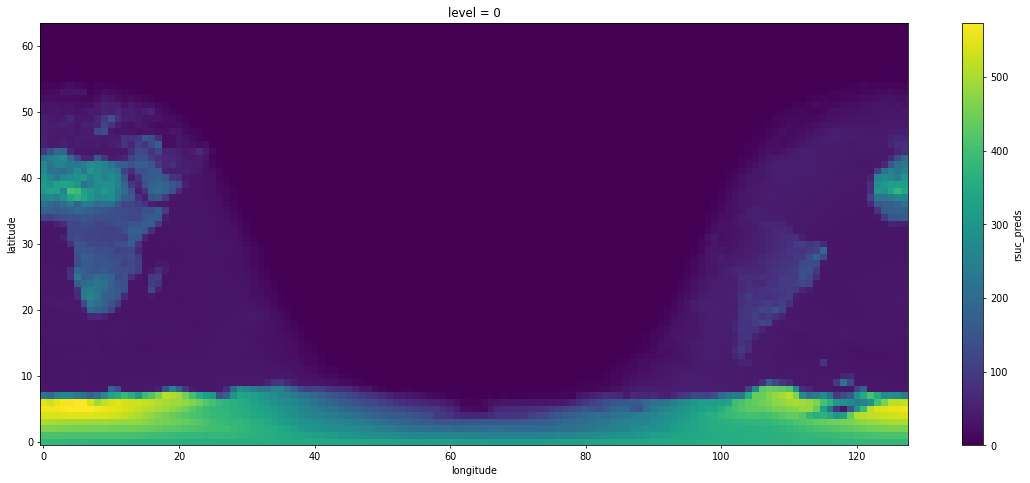

In [78]:
pristine_sw_lw_mlp_pred.rsuc_preds.sel(level=0).plot()

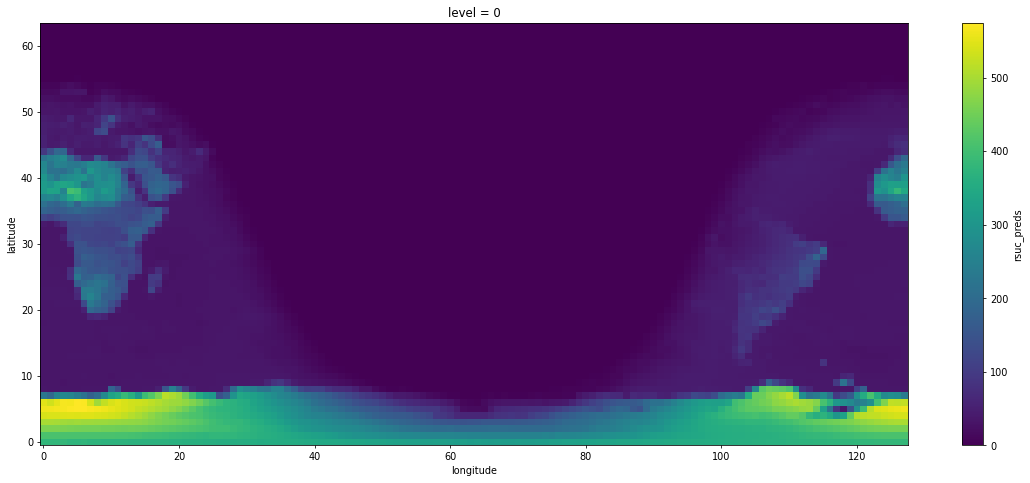

In [39]:
pristine_sw_cnn_pred.rsuc_preds.sel(level=0).plot()

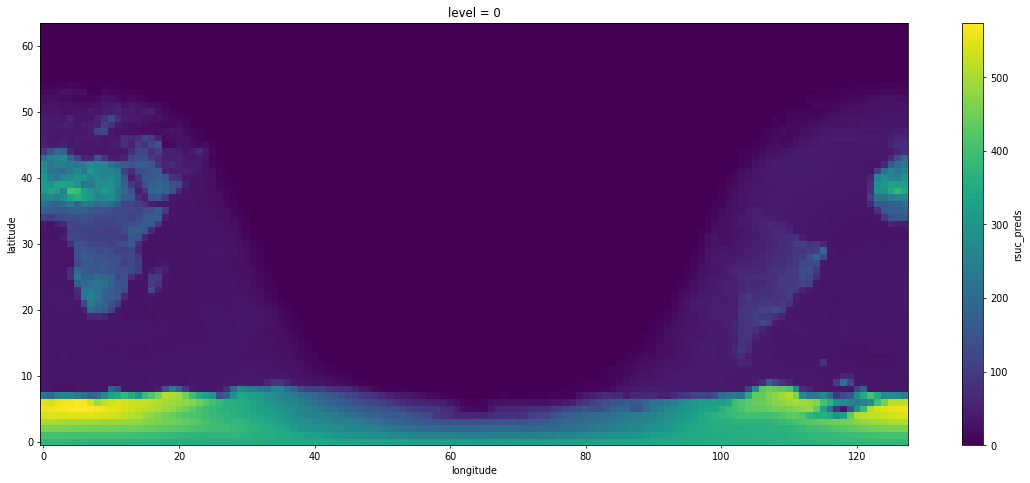

In [40]:
clearsky_sw_lw_mlp_pred.rsuc_preds.sel(level=0).plot()

In [ ]:
if RUN_ALL:
    for model_id in IDs:
        model, normalizer, config = reload_model(model_id)
